## Load Data

In [29]:
# Import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)

In [30]:
# Load data
catagories_df = pd.read_csv("../data/disaster_categories.csv")
messages_df = pd.read_csv("../data/disaster_messages.csv")


for data in [catagories_df,messages_df]:
    display(data.head(3))
    print(data.shape)
    display(data.isna().sum())

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...


(26248, 2)


id            0
categories    0
dtype: int64

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct


(26248, 4)


id              0
message         0
original    16064
genre           0
dtype: int64

## Prep Data

In [31]:
# Merge datasets
df = messages_df.drop('original', axis=1).merge(catagories_df, on='id')
display(df.head(3))
print(df.shape)
display(df.isna().sum())

# Look for duplicates
df[df.duplicated()]

#drop duplicates
df.drop_duplicates(inplace=True)
display("Duplicates: {}".format(df.duplicated().sum()))
print(df.shape)

,id,message,genre,categories
0,2,Weather update - a cold front from Cuba that c...,direct,related-1;request-0;offer-0;aid_related-0;medi...
1,7,Is the Hurricane over or is it not over,direct,related-1;request-0;offer-0;aid_related-1;medi...
2,8,Looking for someone but no name,direct,related-1;request-0;offer-0;aid_related-0;medi...


(26386, 4)


id            0
message       0
genre         0
categories    0
dtype: int64

'Duplicates: 0'

(26216, 4)


In [32]:
### Split catagories

def split_catagories(row):
    cat_count_dict = {}
    cat_list = row.split(';')
    for cat_val in cat_list:
        cat, val = cat_val.split('-')
        cat_count_dict[cat] = val
    return cat_count_dict

df = df.drop('id', axis=1).reset_index()

categories = pd.DataFrame(list(df['categories'][:].apply(split_catagories))).reset_index()
df = df.merge(categories, on='index')
df.drop(['categories', 'index'], axis=1, inplace=True)

for col in df.columns.tolist():
    if col not in ['message', 'genre']:
        df[col] = df[col].astype('int')

## Explore Data

In [33]:
# Tidy up categories
long_df = df.melt(id_vars=['message', 'genre'], var_name='Category')

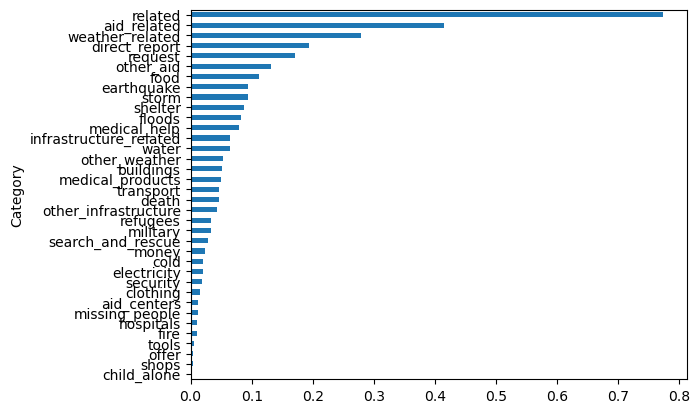

In [34]:
# Plot relative frequency of categories
cat_counts = (long_df.groupby('Category')['value'].sum()/df.shape[0]).sort_values()[:].plot.barh()

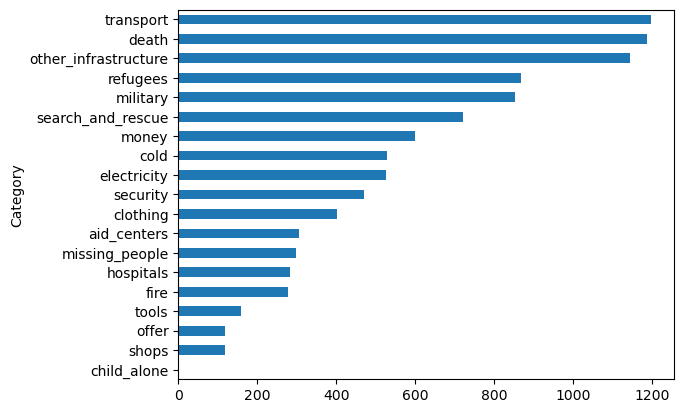

In [35]:
# Plot bottom 50% of categories
cat_counts = long_df.groupby('Category')['value'].sum().sort_values()[:19].plot.barh()

## Models

In [36]:
sample_size = df.shape[0]

### Prep Data

In [37]:
for col in df.drop('message', axis=1).columns.values:
    display(df[col].unique())

array(['direct', 'social', 'news'], dtype=object)

array([1, 0, 2])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

array([0, 1])

In [38]:
# convert values of 2 to 1 in first category
df.loc[df['related'] == 2,'related'] = 1
df['related'].unique()

array([1, 0])

In [39]:
# Remove child alone as it has all zeros only
df.drop(['genre', 'child_alone'], axis=1, inplace=True)

In [40]:
# ML Packages
from nltk.tokenize import wordpunct_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

### Baseline Model: KNN

In [41]:
### Text processing
def tokenize(text):
    # Replace all urls with a urlplaceholder string
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    # Extract all the urls from the provided text 
    detected_urls = re.findall(url_regex, text)
    
    # Replace url with a url placeholder string
    for detected_url in detected_urls:
        text = text.replace(detected_url, 'url')
    
    words = wordpunct_tokenize(text)
    ##TODO: Lemmatization w/ POS could improve performance ##
    stems =  [PorterStemmer().stem(w) for w in words]

    return stems

print(tokenize(df.message[0]))

['weather', 'updat', '-', 'a', 'cold', 'front', 'from', 'cuba', 'that', 'could', 'pass', 'over', 'haiti']


In [42]:
### Split data
# Use sample while testing code
df_sample = df.sample(sample_size, random_state=42)
class_names = df_sample.drop('message', axis=1).columns.values
X = df_sample.message.values
y = df_sample.drop('message', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [43]:
### ML Pipeline
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(KNeighborsClassifier()))
    ])

In [44]:
### KNN classifier
pipeline.fit(X_train, y_train)

# predict on test data
y_pred = pipeline.predict(X_test)

# display results 
print(classification_report(y_test, y_pred, target_names=class_names))

                        precision    recall  f1-score   support

               related       0.78      0.97      0.86      5007
               request       0.32      0.23      0.27      1119
                 offer       0.00      0.00      0.00        28
           aid_related       0.43      0.34      0.38      2756
          medical_help       0.10      0.02      0.03       539
      medical_products       1.00      0.00      0.01       321
     search_and_rescue       0.00      0.00      0.00       167
              security       0.00      0.00      0.00       124
              military       0.50      0.00      0.01       214
                 water       0.08      0.01      0.02       423
                  food       0.18      0.08      0.11       712
               shelter       0.07      0.01      0.02       623
              clothing       0.00      0.00      0.00       100
                 money       0.00      0.00      0.00       151
        missing_people       0.00      

**Initial Results**

Our baseline testing on the full data set using stemmed tokens and a default KNN classifier resulted in a weighted average f1-score of **.34** and an unweighted average of **.08**. We're using f1-score as our evaluation metric since it's not imperative we prioritize precision or recall. 11 Categories had an f1-score of 0, which supports the need for stratifying imbalanced labels.

**Steps for Improvement**

- Improve text processing
    - Lemmatization
    - Stopwords
- Stratify train test split
    - iterative_train_test_split
- New features
    - length of message
    - number of words in message
- GridSearchCV
    - RandomForestClassifier
    - LinearSVC
    - GradientBoostingClassifier

### Improved Tokenization

In [45]:
### Text processing
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from collections import defaultdict


nltk.download('averaged_perceptron_tagger')
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")


def lemmatize(text):
    # Replace all urls with a urlplaceholder string
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    # Extract all the urls from the provided text 
    detected_urls = re.findall(url_regex, text)
    
    # Replace url with a url placeholder string
    for detected_url in detected_urls:
        text = text.replace(detected_url, 'url')
    
    # Tokenize
    tokens = wordpunct_tokenize(text)

    # Remove stopwords
    rm = set(stopwords.words("english"))
    tokens = list(set(tokens) - rm)

    # Lemmatization w/ POS
    lemma = []
    lmtzr = WordNetLemmatizer()

    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV

    for token, tag in pos_tag(tokens):
        token = lmtzr.lemmatize(token, pos=tag_map[tag[0]])
        lemma.append(token)

    return lemma

lemmatize(df.message[0])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tristenwallace/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/tristenwallace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tristenwallace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/tristenwallace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['cold', 'could', 'Haiti', 'pass', 'update', 'Cuba', 'front', 'Weather', '-']

In [46]:
### ML Pipeline
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=lemmatize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(KNeighborsClassifier()))
    ])

In [47]:
### KNN classifier
pipeline.fit(X_train, y_train)

# predict on test data
y_pred = pipeline.predict(X_test)

# display results 
print(classification_report(y_test, y_pred, target_names=class_names))

                        precision    recall  f1-score   support

               related       0.77      0.97      0.86      5007
               request       0.32      0.25      0.28      1119
                 offer       0.00      0.00      0.00        28
           aid_related       0.43      0.36      0.39      2756
          medical_help       0.08      0.01      0.02       539
      medical_products       0.17      0.00      0.01       321
     search_and_rescue       0.00      0.00      0.00       167
              security       0.00      0.00      0.00       124
              military       0.00      0.00      0.00       214
                 water       0.08      0.02      0.03       423
                  food       0.13      0.05      0.08       712
               shelter       0.05      0.01      0.02       623
              clothing       1.00      0.02      0.04       100
                 money       0.00      0.00      0.00       151
        missing_people       0.00      

Removing stop words and lemmatizing results in ~46% reduction of processing time (due to stop words) and ~3% reduction in f1-score.

### Stratify Test Data

In [48]:
# https://medium.com/gumgum-tech/creating-balanced-multi-label-datasets-for-model-training-and-evaluation-16b6a3a2d912
# https://github.com/trent-b/iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold as mlsKFold

### Split data
# Use sample while testing code
df_sample = df.sample(sample_size, random_state=42)
class_names = df_sample.drop('message', axis=1).columns.values
X = df_sample.message.values
y = df_sample.drop('message', axis=1).values

mskf = mlsKFold(n_splits=2, shuffle=True, random_state=42)

for train_index, test_index in mskf.split(X, y):
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]


TRAIN: [    0     4     8 ... 26041 26043 26044] TEST: [    1     2     3 ... 26040 26042 26045]
TRAIN: [    1     2     3 ... 26040 26042 26045] TEST: [    0     4     8 ... 26041 26043 26044]


In [49]:
### ML Pipeline
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(KNeighborsClassifier()))
    ])

In [50]:
### KNN classifier
pipeline.fit(X_train, y_train)

# predict on test data
y_pred = pipeline.predict(X_test)

# display results 
print(classification_report(y_test, y_pred, target_names=class_names))

                        precision    recall  f1-score   support

               related       0.77      0.94      0.85      9982
               request       0.32      0.37      0.35      2224
                 offer       0.00      0.00      0.00        59
           aid_related       0.44      0.55      0.48      5394
          medical_help       0.11      0.05      0.07      1038
      medical_products       0.17      0.00      0.01       654
     search_and_rescue       0.00      0.00      0.00       361
              security       0.00      0.00      0.00       235
              military       0.00      0.00      0.00       427
                 water       0.07      0.03      0.04       828
                  food       0.17      0.11      0.13      1453
               shelter       0.09      0.04      0.06      1147
              clothing       0.10      0.01      0.02       200
                 money       0.00      0.00      0.00       301
        missing_people       0.00      

Stratification improved weighted f1-score by 9%; from .34 to .37. However, we still have 12 categories with an f1-score of 0, which is depressing.

### New Feature: Message Length

In [51]:
# Create length feature 
df['len'] = df['message'].apply(len)

In [52]:
### Split data
# Use sample while testing code
df_sample = df.sample(sample_size, random_state=42)
class_names = df_sample.drop(['message', 'len'], axis=1).columns.values
X = df_sample[['message', 'len']]
y = df_sample.drop(['message', 'len'], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [53]:
from sklearn.compose import ColumnTransformer

text_transformer = Pipeline(
    [('vecttext', CountVectorizer(tokenizer=tokenize)), ('tfidf', TfidfTransformer())]
)

preprocessor = ColumnTransformer(
    [('text', text_transformer, 'message')], remainder='passthrough'
)

pipeline = Pipeline(
        [('preprocessor', preprocessor), ('clf', MultiOutputClassifier(KNeighborsClassifier()))]
    )

In [54]:
### KNN classifier
pipeline.fit(X_train, y_train)

# predict on test data
y_pred = pipeline.predict(X_test)

# display results 
print(classification_report(y_test, y_pred, target_names=class_names))

                        precision    recall  f1-score   support

               related       0.78      0.89      0.83      5059
               request       0.32      0.18      0.23      1158
                 offer       0.00      0.00      0.00        33
           aid_related       0.44      0.35      0.39      2767
          medical_help       0.35      0.01      0.03       515
      medical_products       0.12      0.00      0.01       316
     search_and_rescue       0.00      0.00      0.00       173
              security       0.00      0.00      0.00       124
              military       0.00      0.00      0.00       235
                 water       0.09      0.00      0.01       437
                  food       0.14      0.02      0.04       769
               shelter       0.06      0.01      0.01       593
              clothing       0.00      0.00      0.00       101
                 money       0.00      0.00      0.00       127
        missing_people       0.00      

Including the message length decreased weighted f1-score by about 9% and will not be included in the model.

### Grid Search

In [55]:
df_sample = df.sample(sample_size, random_state=42)
class_names = df_sample.drop('message', axis=1).columns.values
X = df_sample.message.values
y = df_sample.drop('message', axis=1).values
X_train_, X_test, y_train, y_test = train_test_split(X, y)

In [56]:
# Grid search algorithms and parameters
results = []

parameters = [ \
    {
        'clf': [RandomForestClassifier()],
        'clf__estimator__min_samples_split': [5, 50],
        'clf__estimator__max_depth': [5, 8],
        'clf__estimator__random_state': [42]
    },
    {
        'clf': [LinearSVC()],
        'clf__estimator__C': [1.0, 10.0],
        'clf__estimator__max_iter': [5000],
        'clf__estimator__random_state': [42]
    },
    {
        'clf': [GradientBoostingClassifier()],
        'clf__estimator__n_estimators': [100, 200],
        'clf__estimator__min_samples_split': [5],
        'clf__estimator__random_state': [42]
    }]

for params in parameters:
    # Classifier
    clf = MultiOutputClassifier(params['clf'][0])

    # Get args by popping out classifier
    params.pop('clf')

    # pipeline
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=lemmatize)),
        ('tfidf', TfidfTransformer()),
        ('clf', clf)
    ])

    # Cross validation using grid search
    #f1_weighted captures inbalance in label frequency
    cv = GridSearchCV(
            pipeline, 
            params, 
            cv=3,
            scoring = 'f1_weighted')
    cv.fit(X, y)

    # Store result
    results.append( \
            {
                'classifier': cv.best_estimator_,
                'best_params': cv.best_params_,
                'best_score': cv.best_score_
            }
        )
    


KeyboardInterrupt: 